# Bayesian Modeling

This jupyter notebook accompanies the Bayesian Modeling lecture(s) delivered by Justin Alsing and Stephen Feeney as part of [Astro Hack Week 2019](http://astrohackweek.org/2019/). As part of the lecture(s) you will be asked to complete a number of tasks, some of which will involve direct coding into the notebook; these sections are marked by task. This notebook requires numpy, matplotlib, scipy, [corner](https://corner.readthedocs.io/en/latest/), [pystan](https://pystan.readthedocs.io/en/latest/getting_started.html) and pickle to run (the last two are required solely for the final task). If you don't have these packages fret not: the notebook can be run on [Google Colab](https://colab.research.google.com/github/sfeeney/ahw19/blob/master/ahw_complete.ipynb).

We start with imports...

In [1]:
from __future__ import print_function

# make sure everything we need is installed if running on Google Colab
def is_colab():
    try:
        cfg = get_ipython().config
        if cfg['IPKernelApp']['kernel_class'] == 'google.colab._kernel.Kernel':
            return True
        else:
            return False
    except NameError:
        return False
if is_colab():
    !pip install --quiet numpy matplotlib scipy corner pystan

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as mp
import scipy.stats as sps
%matplotlib inline

## Task 1

Write a Python function simulating a very simple linear process observed at known positions $x$ with Gaussian measurement noise: $\hat{y} = m x + c + n$, where $n \sim N(0, \sigma^2)$.

In [8]:
# prior settings
mu_slope = 1.0
sig_slope = 0.1
mu_intcpt = 0.0
sig_intcpt = 0.05
mu_var_noise = 0.02
var_var_noise = mu_var_noise ** 2 / 9.0
shape_var_noise = mu_var_noise ** 2 / var_var_noise + 2.0
scale_var_noise = mu_var_noise * (mu_var_noise ** 2 / var_var_noise + 1.0)

# super-simple wrapper
def x_grid(n_x, x_min=0.0, x_max=1.0):
    
    return np.linspace(x_min, x_max, n_x)

In [9]:
# draw sample from parameter prior
def sample_prior(mu_slope, sig_slope, mu_intcpt, sig_intcpt):
    
    pars = np.zeros(2)
    pars[0] = npr.normal(mu_slope, sig_slope)
    pars[1] = npr.normal(mu_intcpt, sig_intcpt)
    
    return pars

# generate noisy data given parameters
def sample_data(x, pars, var_noise):
    
    y = pars[0] * x + pars[1] + npr.normal(0.0, np.sqrt(var_noise), len(x))
    
    return y

# most basic simulator function: noisy measurements at known locations
def simulator(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, var_noise):
    
    # draw parameters from prior
    pars = sample_prior(mu_slope, sig_slope, mu_intcpt, sig_intcpt)
    
    # generate data
    y = sample_data(x, pars, var_noise)
    
    return [pars, y]

# draw sample from parameter prior
def sample_prior_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise):
    
    pars = np.zeros(3)
    pars[0] = npr.normal(mu_slope, sig_slope)
    pars[1] = npr.normal(mu_intcpt, sig_intcpt)
    pars[2] = 1.0 / npr.gamma(shape_var_noise, 1.0 / scale_var_noise)
    
    return pars

# generate noisy data given parameters
def sample_data_nv(x, pars):
    
    y = pars[0] * x + pars[1] + npr.normal(0.0, np.sqrt(pars[2]), len(x))
    
    return y

# more advanced simulator function: noisy measurements at known locations with unknown noise variance
def simulator_nv(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise):
    
    # draw parameters from prior
    pars = sample_prior_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt)
    
    # generate data
    y = sample_data_nv(x, pars)
    
    return [pars, y]

Let's put together some quick checks that everything's working as planned. First, plot some draws from the prior...

parameter means & standard deviations
* m
  reals:   1.0003807821557449 0.10103056978013386
  theory:  1.0 0.1
* c
  reals:   0.0005964905355898469 0.05002803966084192
  theory:  0.0 0.05


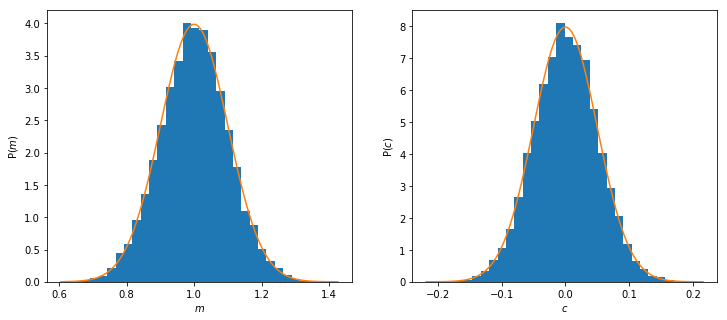

In [10]:
# lots of draws from priors
pars = []
for i in range(10000):
    pars.append(sample_prior(mu_slope, sig_slope, mu_intcpt, sig_intcpt))
pars = np.array(pars)
par_names = [r'm', r'c']

# plot versus expectations
print('parameter means & standard deviations')
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    print('*', par_names[i])
    print('  reals:  ', np.mean(pars[:, i]), np.std(pars[:, i]))
    _ = axes[i].hist(pars[:, i], bins=30, density=True)
    par_lims = axes[i].get_xlim()
    par_grid = np.linspace(par_lims[0], par_lims[1], 100)
    axes[i].set_xlabel('$' + par_names[i] + '$')
    axes[i].set_ylabel(r'${\rm P(}' + par_names[i] + ')$')
    if i == 0:
        print('  theory: ', mu_slope, sig_slope)
        axes[i].plot(par_grid, sps.norm.pdf(par_grid, mu_slope, sig_slope))
    elif i == 1:
        print('  theory: ', mu_intcpt, sig_intcpt)
        axes[i].plot(par_grid, sps.norm.pdf(par_grid, mu_intcpt, sig_intcpt))

... and now some simulated data to check noise distribution.

noise mean & standard deviation
  reals:   -0.0011924796372443673 0.14234290847054817
  theory:  0.0 0.1414213562373095


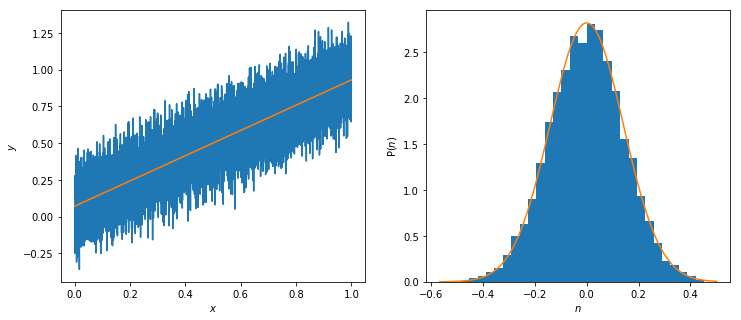

In [12]:
# draw a large data realization with fixed noise variance
x = x_grid(10000)
pars, y = simulator(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, mu_var_noise)
noise = y - (pars[0] * x + pars[1])

# plot noise histogram versus expectation
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x, y)
axes[0].plot(x, pars[0] * x + pars[1])
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
_ = axes[1].hist(noise, bins=30, density=True)
par_lims = axes[1].get_xlim()
par_grid = np.linspace(par_lims[0], par_lims[1], 100)
axes[1].plot(par_grid, sps.norm.pdf(par_grid, 0.0, np.sqrt(mu_var_noise)))
axes[1].set_xlabel('$n$')
axes[1].set_ylabel(r'${\rm P(}n)$')
print('noise mean & standard deviation')
print('  reals:  ', np.mean(noise), np.std(noise))
print('  theory: ', 0.0, np.sqrt(mu_var_noise))

In [ ]:
# hacky way of drawing from priors
x = x_grid(2)
pars = []
for i in range(10000):
    p, y = lin_proc_noisy_y(x)
    pars.append(p)
pars = np.array(pars)
par_names = [r'm', r'c', r'\sigma_{\rm noise}^2']

# plot versus expectations
print('parameter means & standard deviations')
fig, axes = mp.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    print('*', par_names[i])
    print('  reals:  ', np.mean(pars[:, i]), np.std(pars[:, i]))
    _ = axes[i].hist(pars[:, i], bins=30, density=True)
    par_lims = axes[i].get_xlim()
    par_grid = np.linspace(par_lims[0], par_lims[1], 100)
    axes[i].set_xlabel('$' + par_names[i] + '$')
    axes[i].set_ylabel(r'${\rm P(}' + par_names[i] + ')$')
    if i == 0:
        print('  theory: ', mu_slope, sig_slope)
        axes[i].plot(par_grid, sps.norm.pdf(par_grid, mu_slope, sig_slope))
    elif i == 1:
        print('  theory: ', mu_intcpt, sig_intcpt)
        axes[i].plot(par_grid, sps.norm.pdf(par_grid, mu_intcpt, sig_intcpt))
    elif i == 2:
        print('  theory: ', mu_var_noise, np.sqrt(var_var_noise))
        axes[i].plot(par_grid, sps.invgamma.pdf(par_grid, shape_var_noise, scale=scale_var_noise))

In [ ]:
# draw a larger data realization
x = x_grid(1000)
pars, y = lin_proc_noisy_y(x)
noise = y - (pars[0] * x + pars[1])

# plot noise histogram versus expectation
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x, y)
axes[0].plot(x, pars[0] * x + pars[1])
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
_ = axes[1].hist(noise, bins=30, density=True)
par_lims = axes[1].get_xlim()
par_grid = np.linspace(par_lims[0], par_lims[1], 100)
axes[1].plot(par_grid, sps.norm.pdf(par_grid, 0.0, np.sqrt(pars[2])))
axes[1].set_xlabel('$n$')
axes[1].set_ylabel(r'${\rm P(}n)$')
print('noise mean & standard deviation')
print('  reals:  ', np.mean(noise), np.std(noise))
print('  theory: ', 0.0, np.sqrt(pars[2]))

## Task 2

Code up the gridded posterior. Let's split this into two parts. First, write three functions evaluating the log-likelihood, log-prior and log-posterior for a set of sampled parameters. These will be very useful in the future.

In [14]:
def ln_like(pars, x, y, var_noise):
    delta = y - (pars[0] * x + pars[1])
    cinv = np.diag(np.ones(len(x)) / var_noise)
    return -0.5 * np.dot(np.dot(delta, cinv), delta)

def ln_prior(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt):
    return -0.5 * (((pars[0] - mu_slope) / sig_slope) ** 2 + ((pars[1] - mu_intcpt) / sig_intcpt) ** 2)

def ln_post(pars, x, y, var_noise, mu_slope, sig_slope, mu_intcpt, sig_intcpt):
    return ln_like(pars, x, y, var_noise) + \
           ln_prior(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt)

Now evaluate the posterior on a grid of parameters.

In [ ]:
# generate a smaller data realization
x = x_grid(100)
pars, y = simulator(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, mu_var_noise)

# and calculate its parameter posterior on a grid
n_grid = 100
slope_grid = np.linspace(mu_slope - 3.0 * sig_slope, mu_slope + 3.0 * sig_slope, n_grid+1)
intcpt_grid = np.linspace(mu_intcpt - 3.0 * sig_intcpt, mu_intcpt + 3.0 * sig_intcpt, n_grid)
post = np.zeros((n_grid+1, n_grid))
for i in range(n_grid+1):
    for j in range(n_grid):
        post[i, j] = np.exp(ln_post([slope_grid[i], intcpt_grid[j]], x, y, mu_var_noise, mu_slope, \
                                    sig_slope, mu_intcpt, sig_intcpt))

Now plot the joint posterior and the two one-dimensional marginal distributions.

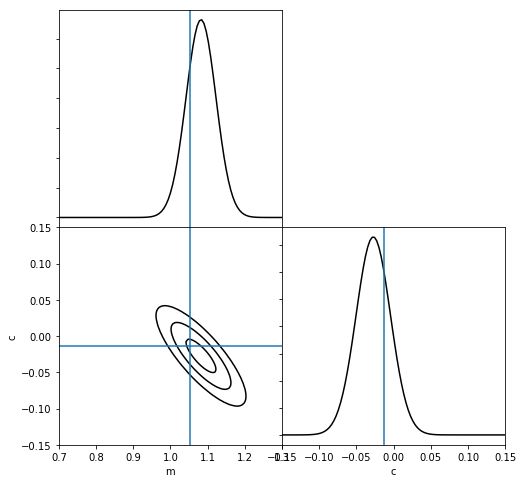

In [109]:
# plot joint and marginal posteriors
fig, axes = mp.subplots(2, 2, figsize=(8, 8))
levels = np.array([0.011109, 0.13533528, 0.60653066]) * np.max(post)
axes[0, 0].plot(slope_grid, np.sum(post, axis=1), color='k')
axes[1, 1].plot(intcpt_grid, np.sum(post, axis=0), color='k')
axes[1, 0].contour(slope_grid, intcpt_grid, post.T, levels=levels, colors='k')

# prettify
axes[0, 0].axvline(pars[0])
axes[0, 0].set_xticklabels([])
axes[0, 0].set_yticklabels([])
axes[0, 0].set_xlim(axes[1, 0].get_xlim())
axes[1, 0].axvline(pars[0])
axes[1, 0].axhline(pars[1])
axes[1, 0].set_xlabel(par_names[0])
axes[1, 0].set_ylabel(par_names[1])
axes[1, 1].set_xlim(axes[1, 0].get_ylim())
axes[1, 1].axvline(pars[1])
axes[1, 1].set_yticklabels([])
axes[1, 1].set_xlabel(par_names[1])
fig.delaxes(axes[0, 1])
fig.subplots_adjust(hspace=0, wspace=0)

In order to plot the outputs of the GLS fit we could draw a large number of samples from the resulting multivariate Gaussian posterior and pass them to something like [`corner`](https://corner.readthedocs.io/en/latest/); however, as we have analytic results we might as well use those directly. I've coded up something totally hacky here in order to do so, and included it in the cell below. Information on how to draw confidence ellipses can be found in [Dan Coe's note](https://arxiv.org/pdf/0906.4123.pdf).

In [ ]:
# posteriors
import matplotlib.patches as mpp
def schmorner(par_mean, par_cov, par_true, par_label):
    
    # setup
    par_std = np.sqrt(np.diag(par_cov))
    x_min = par_mean[0] - 3.5 * par_std[0]
    x_max = par_mean[0] + 3.5 * par_std[0]
    y_min = par_mean[1] - 3.5 * par_std[1]
    y_max = par_mean[1] + 3.5 * par_std[1]
    fig, axes = mp.subplots(2, 2)
    
    # 1D marge
    x = np.linspace(x_min, x_max, 100)
    axes[0, 0].plot(x, sps.norm.pdf(x, par_mean[0], par_std[0]), 'k')
    axes[0, 0].axvline(par_true[0])
    axes[1, 0].axvline(par_true[0])
    axes[0, 0].set_xticklabels([])
    axes[0, 0].set_yticklabels([])
    axes[0, 0].set_xlim(x_min, x_max)
    axes[0, 0].set_title(par_label[0])
    axes[0, 0].set_title(par_label[0] + r'$=' + '{:7.3f}'.format(par_mean[0]) + \
                         r'\pm' + '{:5.3f}'.format(par_std[0]) + r'$')
    y = np.linspace(y_min, y_max, 100)
    axes[1, 1].plot(y, sps.norm.pdf(y, par_mean[1], par_std[1]), 'k')
    axes[1, 0].axhline(par_true[1])
    axes[1, 1].axvline(par_true[1])
    axes[1, 1].tick_params(labelleft=False)
    axes[1, 1].set_xlim(y_min, y_max)
    axes[1, 1].set_xlabel(par_label[1])
    for tick in axes[1, 1].get_xticklabels():
        tick.set_rotation(45)
    axes[1, 1].set_title(par_label[1] + r'$=' + '{:6.3f}'.format(par_mean[1]) + \
                         r'\pm' + '{:5.3f}'.format(par_std[1]) + r'$')

    # 2D marge
    vals, vecs = np.linalg.eig(par_cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))
    w, h = 2 * np.sqrt(vals)
    ell = mpp.Ellipse(xy=par_mean, width=w, height=h,
                      angle=theta, color='k')
    ell.set_facecolor("none")
    axes[1, 0].add_artist(ell)
    ell = mpp.Ellipse(xy=par_mean, width=2*w, height=2*h,
                      angle=theta, color='k')
    ell.set_facecolor("none")
    axes[1, 0].add_artist(ell)
    axes[1, 0].set_xlim(x_min, x_max)
    axes[1, 0].set_ylim(y_min, y_max)
    for tick in axes[1, 0].get_xticklabels():
        tick.set_rotation(45)
    for tick in axes[1, 0].get_yticklabels():
        tick.set_rotation(45)
    axes[1, 0].set_xlabel(par_label[0])
    axes[1, 0].set_ylabel(par_label[1])
    fig.delaxes(axes[0, 1])
    fig.subplots_adjust(hspace=0, wspace=0)

In [ ]:
# perform GLS fit for simulated data and plot results!
gls_pars, gls_pars_cov, gls_chisq = gls_fit(x, y, pars[2])
test = schmorner(gls_pars, gls_pars_cov, pars[0: 2], par_names[0: 2])

## Metropolis-Hastings Sampling

The Metropolis-Hastings algorithm is a particularly simple and hence extremely broadly employed Markov-Chain Monte Carlo (MCMC) technique for obtaining samples from a posterior. All this algorithm requires is the ability to evaluate the posterior at any point in parameter space (up to any parameter-independent constants such as the *evidence*), along with a distribution from which to propose movements in parameter space. It is therefore typically the first option considered for settings in which the posterior moments can not be calculated analytically.

The next task is to write down this sampler for our simplest setting: estimating the joint posterior of the slope and intercept, assuming the noise variance is known. Let's split this into two parts, First, write three functions evaluating the log-likelihood, log-prior and log-posterior for a set of sampled parameters. These will be very useful in the future.

In [ ]:
def ln_like(pars, x, y, var_noise):
    delta = y - (pars[0] * x + pars[1])
    cinv = np.diag(np.ones(len(x)) / var_noise)
    return -0.5 * np.dot(np.dot(delta, cinv), delta)

def ln_prior(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt):
    return -0.5 * (((pars[0] - mu_slope) / sig_slope) ** 2 + ((pars[1] - mu_intcpt) / sig_intcpt) ** 2)

def ln_post(pars, x, y, var_noise, mu_slope, sig_slope, mu_intcpt, sig_intcpt):
    return ln_like(pars, x, y, var_noise) + \
           ln_prior(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt)

Next, write the sampler itself: choose a random starting point, then propose a move in parameter space and accept it with the appropriate probability. This requires a proposal distribution. Let's use a multivariate normal, centred on the current sample, with a user-specified covariance matrix.

In [104]:
def mh_sampler(n_samples, x, y, var_noise, mu_slope, sig_slope, mu_intcpt, sig_intcpt, prop_cov):
    
    # setup
    samples = np.zeros((n_samples, 2))
    ln_posts = np.zeros(n_samples)
    
    # draw random starting point from prior
    samples[0, :] = sample_prior(mu_slope, sig_slope, mu_intcpt, sig_intcpt)
    ln_posts[0] = ln_post(samples[0, :], x, y, var_noise, mu_slope, sig_slope, mu_intcpt, sig_intcpt)
    
    # MH algorithm
    for i in range(n_samples - 1):
        
        # propose new point in parameter space
        proposal = npr.multivariate_normal(samples[i, :], prop_cov)
        
        # calculate acceptance probability:
        ln_post_prop = ln_post(proposal, x, y, var_noise, mu_slope, sig_slope, mu_intcpt, sig_intcpt)
        ratio = np.exp(ln_post_prop - ln_posts[i])
        
        # accept or reject?
        if ratio >= npr.rand():
            samples[i + 1, :] = proposal
            ln_posts[i + 1] = ln_post_prop
        else:
            samples[i + 1, :] = samples[i, :]
            ln_posts[i + 1] = ln_posts[i]
    
    return samples, ln_posts

Now let's run the sampler on the simulated data we've generated! To do so, we need to pick a proposal covariance. Let's pick something very simple (and therefore suboptimal): a diagonal matrix with $\sigma$ = 0.02.

In [105]:
prop_cov = np.eye(2) * 0.02 ** 2
npr.seed(12345)
samples, ln_posts = mh_sampler(50000, x, y, mu_var_noise, mu_slope, sig_slope, mu_intcpt, sig_intcpt, prop_cov)

Create a 2D plot showing the samples (the Markov chain) generated. Note the *burn-in* period, in which the sampler hones in on the region of appreciable posterior density from its initial random position. We can discard these samples when estimating the properties of the posterior. Add a so-called *trace plot* of the slope samples showing how the sampler generates correlated samples. Reducing this correlation would result in a (potentially significantly) more efficient sampler.

Text(0,0.5,'m')

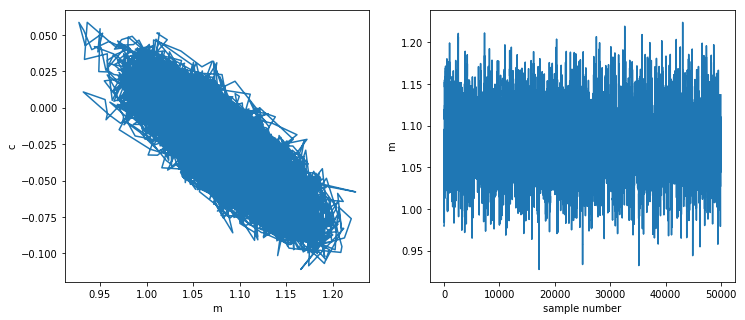

In [106]:
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
axes[0].plot(samples[:, 0], samples[:, 1])
axes[0].set_xlabel(par_names[0])
axes[0].set_ylabel(par_names[1])
axes[1].plot(samples[:, 0])
axes[1].set_xlabel('sample number')
axes[1].set_ylabel(par_names[0])

Now let's generate some marginalized parameter posteriors (by simply discarding all samples of the latent parameters) using DFM's [`corner`](https://corner.readthedocs.io/en/latest/) package. Note the near identical nature of this plot to the `schmorner` plot we generated above.

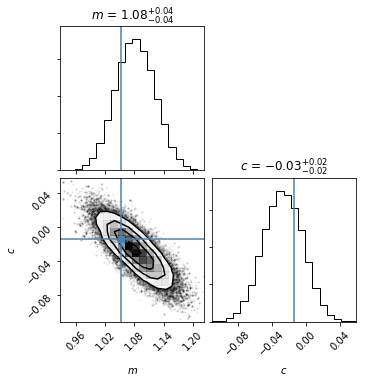

In [107]:
import corner
n_burnin = 100
final_samples = samples[n_burnin:, :]
par_names_co = ['$' + par_name + '$' for par_name in par_names]
fig = corner.corner(final_samples, labels=par_names_co[0: 2], show_titles=True, truths=pars[0: 2])

There are many ways to play around with this simple sampler. Let's do a quick demonstration of the importance of the proposal distribution. For our chosen proposal, the covariance matrix tells the sampler how to try stepping around the posterior. The efficiency of this process strongly depends on how closely the proposal distribution matches the target posterior.

Try out a couple of other choices for the proposal--one larger and one smaller than the current value--and see how the sampler performs. Plotting both the 2D samples and the slope trace plot will help us investigate the sampler's behaviour.

In [ ]:
n_samples = 10000
sig_props = np.array([0.002, 0.2])
samples = np.zeros((n_samples, 2, 2))
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    npr.seed(12345)
    prop_cov = np.eye(2) * sig_props[i] ** 2
    samples[:, :, i], ln_posts = mh_sampler(n_samples, x, y, pars[2], mu_slope, sig_slope, mu_intcpt, \
                                            sig_intcpt, prop_cov)
    axes[0].plot(samples[:, 0, i], samples[:, 1, i], label=r'$\sigma_{\rm prop}$'+'={:5.3f}'.format(sig_props[i]))
    axes[1].plot(samples[:, 0, i], label=r'$\sigma_{\rm prop}$'+'={:5.3f}'.format(sig_props[i]))
axes[0].set_xlabel(par_names[0])
axes[0].set_ylabel(par_names[1])
axes[0].legend(loc='upper right')
axes[1].set_xlabel('sample number')
axes[1].set_ylabel(par_names[0])
axes[1].legend(loc='upper right')

If the proposal $\sigma$ is too small, the sampler makes very small steps around the posterior, producing highly correlated samples. If $\sigma$ is too large, the sampler rejects most proposals, remaining stationary most of the time. In both cases the sampler is inefficient, taking an unnecessarily large number of samples to explore the posterior. Tuning the proposal is therefore an integral part of the MH algorithm.

Another change we can explore is to add another parameter and estimate the noise variance as we infer the slope and intercept. Adapt our existing code to extend the inference below. Note that we must rewrite both our likelihood and prior functions in this case: the latter for obvious reasons; the former because we previously dropped the $\sigma_{\rm noise}$-dependent determinant term. We must also complicate them a little, as we need to gracefully handle the sampler proposing negative (i.e., forbidden) values for the variance. We can do so by checking the proposed parameters (e.g., `if pars[2] <= 0.0`) or the outputs of the likelihood and prior functions (which is perhaps a more general check) and returning a large negative log-probability if a problem was found.

In [ ]:
def ln_like_nv(pars, x, y):
    
    ln_sqrt_det = -0.5 * len(x) * np.log(pars[2])
    
    return ln_like(pars[0: 2], x, y, pars[2]) + ln_sqrt_det

def ln_prior_nv(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise):
    
    ln_prior_reg = ln_prior(pars[0: 2], mu_slope, sig_slope, mu_intcpt, sig_intcpt)
    ln_prior_noise = (-shape_var_noise - 1.0) * np.log(pars[2]) - scale_var_noise / pars[2]
    
    return ln_prior_reg + ln_prior_noise

def ln_post_nv(pars, x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise):
    
    if pars[2] <= 0.0:
        return -1.0e90
    else:
        return ln_like_nv(pars, x, y) + \
               ln_prior_nv(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise)

def prior_sample_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                    scale_var_noise):
    
    sample = np.zeros(3)
    sample[0: 2] = prior_sample(mu_slope, sig_slope, mu_intcpt, sig_intcpt)
    sample[2] = 1.0 / npr.gamma(shape_var_noise, 1.0 / scale_var_noise)
    
    return sample

def mh_sampler_nv(n_samples, x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                  scale_var_noise, prop_cov):
    
    # setup
    samples = np.zeros((n_samples, 3))
    ln_posts = np.zeros(n_samples)
    
    # draw random starting point from prior
    samples[0, :] = prior_sample_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                                    scale_var_noise)
    ln_posts[0] = ln_post_nv(samples[0, :], x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                             shape_var_noise, scale_var_noise)
    
    # MH algorithm
    for i in range(n_samples - 1):
        
        # propose new point in parameter space
        proposal = npr.multivariate_normal(samples[i, :], prop_cov)
        
        # calculate acceptance probability:
        ln_post_prop = ln_post_nv(proposal, x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                  shape_var_noise, scale_var_noise)
        ratio = np.exp(ln_post_prop - ln_posts[i])
        
        # accept or reject?
        if ratio >= npr.rand():
            samples[i + 1, :] = proposal
            ln_posts[i + 1] = ln_post_prop
        else:
            samples[i + 1, :] = samples[i, :]
            ln_posts[i + 1] = ln_posts[i]
    
    return samples, ln_posts

Now run the sampler for the simulated data. To do so, you'll need to specify a 3x3 proposal covariance that takes into account the fact that the variance is much smaller than the other two parameters and should therefore be sampled with finer steps.

In [ ]:
prop_cov = np.diag([0.02, 0.02, 0.002]) ** 2
npr.seed(12345)
samples, ln_posts = mh_sampler_nv(50000, x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                  shape_var_noise, scale_var_noise, prop_cov)
n_burnin = 100
final_samples = samples[n_burnin:, :]
fig = corner.corner(final_samples, labels=par_names_co, show_titles=True, truths=pars)

## More sophisticated MCMC

[emcee](https://emcee.readthedocs.io/en/stable/) implements an affine-invariant ensemble sampling algorithm that reduces the tuning needed for efficient exploration of an $N$-dimensional posterior from $\sim N^2/2$ parameters (i.e., a covariance matrix) to just 2, thereby enabling sampling in larger numbers of dimensions than Metropolis-Hastings. It also has a particularly simple interface, whereby the user only has to specify a function calculating the log-posterior (in exactly the format we've developed above, hooray!), a number of walkers to use and a starting point. Let's plug our problem into emcee.

In [ ]:
import emcee
n_walkers = 50
n_dim = 3

init_pos = np.zeros((n_walkers, n_dim))
for i in range(n_walkers):
    init_pos[i, :] = prior_sample_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                                     scale_var_noise)
args = [x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise]
sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_post_nv, args=args)
pos, prob, state = sampler.run_mcmc(init_pos, 200)
print('* burned in')
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)
print('* sampling complete')

In [ ]:
flat_samples = sampler.flatchain
fig = corner.corner(flat_samples, labels=par_names_co, show_titles=True, truths=pars)

TODO:

comments and explanation for new stuff, esp emcee

emcee checks? acceptance frac?

reduce number of samples? i guess we still have 50k

FLATTEN LIKELIHOOD!!!

## A harder problem: errors on measurement positions

Move on to the problem in which there is uncertainty in the measurement positions. This a significantly harder inference problem, as we must infer the measurement positions as well as the regression parameters. First, re-write the simulator to generate uncertain measurement positions. Consider a (much!) smaller dataset so as to not overwhelm emcee.

In [ ]:
# prior settings
n_x = 10
mu_x = np.linspace(0.0, 1.0, n_x)
sig_x = 0.025
sig_noise_x = 0.05

# simulation code accounting for uncertainties in measurement positions
def lin_proc_noisy_xy(mu_x, sig_x=sig_x, sig_noise_x=sig_noise_x, mu_slope=mu_slope, sig_slope=sig_slope, \
                      mu_intcpt=mu_intcpt, sig_intcpt=sig_intcpt, shape_var_noise=shape_var_noise, \
                      scale_var_noise=scale_var_noise):
    
    # draw positions from prior
    n_x = len(mu_x)
    x_true = npr.randn(n_x) * sig_x + mu_x
    
    # generate observed measurement positions
    x_obs = npr.randn(n_x) * sig_noise_x + x_true
    
    # generate remaining parameters and data
    pars, y = lin_proc_noisy_y(x_true, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                               shape_var_noise, scale_var_noise)
    
    return [np.concatenate((x_true, pars)), np.concatenate((x_obs, y))]

Generate some data and plot.

In [ ]:
pars_nvx, y_nvx = lin_proc_noisy_xy(mu_x)
mp.plot(y_nvx[0: n_x], y_nvx[n_x:])
mp.xlabel('x')
mp.xlabel('y')

Now make the changes required for inference with emcee:

In [ ]:
# again: tag on to what we've already got
    
# define x_true, x_obs
# pass former to y likelihood, latter to x 

def ln_like_nvx(pars_x, pars_reg, y_x, y_reg, sig_noise_x):
    
    ln_like_x = -0.5 * np.sum(((pars_x - y_x) / sig_noise_x) ** 2)
    
    return ln_like_nv(pars_reg, pars_x, y_reg) + ln_like_x

def ln_prior_nvx(pars_x, pars_reg, mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                 shape_var_noise, scale_var_noise):
    
    ln_prior_x = -0.5 * np.sum(((pars_x - mu_x) / sig_x) ** 2)
    
    return ln_prior_nv(pars_reg, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise) + \
           ln_prior_x

def ln_post_nvx(pars, y, mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                shape_var_noise, scale_var_noise):
    
    # split parameters and observations
    n_pos = len(mu_x)
    pars_x = pars[0: n_pos]
    pars_reg = pars[n_pos:]
    y_x = y[0: n_pos]
    y_reg = y[n_pos:]
    if pars_reg[2] <= 0.0:
        return -1.0e90
    else:
        return ln_like_nvx(pars_x, pars_reg, y_x, y_reg, sig_noise_x) + \
               ln_prior_nvx(pars_x, pars_reg, mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                            shape_var_noise, scale_var_noise)

def prior_sample_nvx(mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                     scale_var_noise):
    
    n_x = len(mu_x)
    sample = np.zeros(n_x + 3)
    sample[0: n_x] = npr.randn(n_x) * sig_x + mu_x
    sample[n_x:] = prior_sample_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                                   scale_var_noise)
    
    return sample

... and see what happens when run on our data!

In [ ]:
n_dim = n_x + 3
init_pos = np.zeros((n_walkers, n_dim))
for i in range(n_walkers):
    init_pos[i, :] = prior_sample_nvx(mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                      shape_var_noise, scale_var_noise)
args = [y_nvx, mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise]
sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_post_nvx, args=args)
pos, prob, state = sampler.run_mcmc(init_pos, 200)
print('* burned in')
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)
print('* sampling complete')

In [ ]:
par_names_nvx = ['x_{:d}'.format(i) for i in range(n_x)] + par_names
par_names_nvx_co = ['$' + par_name + '$' for par_name in par_names_nvx]
flat_samples = sampler.flatchain
fig = corner.corner(flat_samples, labels=par_names_nvx_co, show_titles=True, truths=pars_nvx)

## Task 3B

Below I've written the majority of a Gibbs sampler to infer the hyper-parameters of the Cepheid PL relation from our simulated sample. One component is missing: drawing from the conditional distribution of the standard absolute magnitude, $M^*$. Please fill it in, using the results of whiteboard/paper Task 3A. 

In [ ]:
def gibbs_sample(n_samples, n_gal, n_star, abs_bar, abs_sig, \
                 s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, \
                 m_sig_int, m_hat_sig, mu_hat, lp_true, m_hat):
    
    # storage
    abs_samples = np.zeros(n_samples)
    s_samples = np.zeros(n_samples)
    mu_samples = np.zeros((n_gal, n_samples))
    m_samples = np.zeros((n_gal, n_star, n_samples))
    
    # initialize sampler
    abs_samples[0] = abs_bar + npr.randn() * abs_sig
    s_samples[0] = s_bar + npr.randn() * s_sig
    mu_samples[:, 0] = mu_bar + npr.randn(n_gal) * mu_bar
    for i in range(n_gal):
        m_samples[i, :, 0] = mu_samples[i, 0] + abs_samples[0] + s_samples[0] * lp_true[i, :]
    
    # sample!
    for i in range(1, n_samples):
        
        # sample abs mag
        abs_sig_pl = m_sig_int / np.sqrt(n_gal * n_star)
        abs_bar_pl = 0.0
        for j in range(n_gal):
            abs_bar_pl += np.sum(m_samples[j, :, i - 1] - mu_samples[j, i - 1] - s_samples[i - 1] * lp_true[j, :])
        abs_bar_pl /= (n_gal * n_star)
        abs_std = np.sqrt((abs_sig * abs_sig_pl) ** 2 / (abs_sig ** 2 + abs_sig_pl ** 2))
        abs_mean = (abs_sig ** 2 * abs_bar_pl + abs_sig_pl ** 2 * abs_bar) / \
                   (abs_sig ** 2 + abs_sig_pl ** 2)
        abs_samples[i] = abs_mean + npr.randn() * abs_std
        
        # sample slope
        s_sig_pl = m_sig_int / np.sqrt(np.sum(lp_true ** 2))
        s_bar_pl = 0.0
        for j in range(n_gal):
            s_bar_pl += np.sum((m_samples[j, :, i - 1] - mu_samples[j, i - 1] - abs_samples[i]) * lp_true[j, :])
        s_bar_pl /= np.sum(lp_true ** 2)
        s_std = np.sqrt((s_sig * s_sig_pl) ** 2 / (s_sig ** 2 + s_sig_pl ** 2))
        s_mean = (s_sig ** 2 * s_bar_pl + s_sig_pl ** 2 * s_bar) / \
                 (s_sig ** 2 + s_sig_pl ** 2)
        s_samples[i] = s_mean + npr.randn() * s_std
        
        # sample apparent magnitudes
        for j in range(n_gal):
            m_mean_pl = mu_samples[j, i - 1] + abs_samples[i] + s_samples[i] * lp_true[j, :]
            m_std = np.sqrt(m_sig_int ** 2 * m_hat_sig ** 2 / (m_sig_int ** 2 + m_hat_sig ** 2))
            m_mean = (m_sig_int ** 2 * m_hat[j, :] + m_hat_sig ** 2 * m_mean_pl) / (m_sig_int ** 2 + m_hat_sig ** 2)
            m_samples[j, :, i] = m_mean + npr.randn(n_star) * m_std
            
        # sample distance moduli
        mu_sig_pl = m_sig_int / np.sqrt(n_star)
        mu_bar_pl = np.mean(m_samples[0, :, i] - abs_samples[i] - s_samples[i] * lp_true[0, :])
        mu_var = 1.0 / (1.0 / mu_sig ** 2 + 1.0 / mu_hat_sig ** 2 + 1.0 / mu_sig_pl ** 2)
        mu_mean = (mu_bar / mu_sig ** 2 + mu_hat / mu_hat_sig ** 2 + mu_bar_pl / mu_sig_pl ** 2) * mu_var
        mu_samples[0, i] = mu_mean + npr.randn() * np.sqrt(mu_var)
        for j in range(1, n_gal):
            mu_sig_pl = m_sig_int / np.sqrt(n_star)
            mu_bar_pl = np.mean(m_samples[j, :, i] - abs_samples[i] - s_samples[i] * lp_true[j, :])
            mu_std = (mu_sig * mu_sig_pl) ** 2 / (mu_sig ** 2 + mu_sig_pl ** 2)
            mu_mean = (mu_sig ** 2 * mu_bar_pl + mu_sig_pl ** 2 * mu_bar) / \
                      (mu_sig ** 2 + mu_sig_pl ** 2)
            mu_samples[j, i] = mu_mean + npr.randn() * mu_std
        
    return (abs_samples, s_samples, mu_samples, m_samples)

Now let's sample, setting aside the first half of the samples as warmup.

In [ ]:
all_samples = gibbs_sample(n_samples, n_gal, n_star, abs_bar, abs_sig, \
                           s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, \
                           m_sig_int, m_hat_sig, mu_hat, lp_true, m_hat)
n_warmup = int(n_samples / 2)
g_samples = [samples[n_warmup:] for samples in all_samples]

Let's make sure that the absolute magnitude is being inferred as expected. First, generate a trace plot of the absolute magnitude samples (the first entry in `g_samples`), overlaying the ground truth. Then print out the mean and standard deviation of the marginalized absolute magnitude posterior. Recall that marginalizing is as simple as throwing away the samples of all other parameters.

In [ ]:
mp.plot(g_samples[0])
mp.axhline(abs_true)
mp.xlabel('sample')
mp.ylabel(r'$M^*$')
print('Truth {:6.2f}; inferred {:6.2f} +/- {:4.2f}'.format(abs_true, np.mean(g_samples[0]), np.std(g_samples[0])))

Now let's generate some marginalized parameter posteriors (by simply discarding all samples of the latent parameters) using DFM's [`corner`](https://corner.readthedocs.io/en/latest/) package. Note the near identical nature of this plot to the `schmorner` plot we generated above.

In [ ]:
import corner
samples = np.stack((g_samples[0], g_samples[1]))
fig = corner.corner(samples.T, labels=[r"$M^*$", r"$s$"],
                    show_titles=True, truths=[abs_true, s_true])

## Task 4

The final task is to write a [Stan model](https://pystan.readthedocs.io/en/latest/getting_started.html) to infer the parameters of the period-luminosity relation. I've coded up the other two blocks required (`data` and `parameters`), so all that is required is for you to write the joint posterior (factorized into its individual components) in Stan's sampling-statement-based syntax. Essentially all you need are Gaussian sampling statements (`abs_true ~ normal(abs_bar, abs_sig);`) and for loops (`for(i in 1: n_gal){...}`).

When you evaluate this cell, Stan will translate your model into `c++` code and compile it. We will then pickle the compiled model so you can re-use it rapidly without recompiling. To do so, please set `recompile = False` in the notebook.

In [ ]:
import sys
import pystan as ps
import pickle

stan_code = """
data {
    int<lower=0> n_gal;
    int<lower=0> n_star;
    real mu_hat;
    real mu_hat_sig;
    real m_hat[n_gal, n_star];
    real m_hat_sig;
    real m_sig_int;
    real lp_true[n_gal, n_star];
    real abs_bar;
    real abs_sig;
    real s_bar;
    real s_sig;
    real mu_bar;
    real mu_sig;
}
parameters {
    real mu_true[n_gal];
    real m_true[n_gal, n_star];
    real abs_true;
    real s_true;
}
model {
    // priors
    abs_true ~ normal(abs_bar, abs_sig);
    s_true ~ normal(s_bar, s_sig);
    mu_true ~ normal(mu_bar, mu_sig);
    
    // whatevers
    for(i in 1: n_gal){
        for(j in 1: n_star){
            m_true[i, j] ~ normal(mu_true[i] + abs_true + s_true * lp_true[i, j], m_sig_int);
        }
    }
    
    // likelihoods
    mu_hat ~ normal(mu_true[1], mu_hat_sig);
    for(i in 1: n_gal){
        for(j in 1: n_star){
            m_hat[i, j] ~ normal(m_true[i, j], m_hat_sig);
        }
    }
}
"""
n_samples_stan = 5000
recompile = False
pkl_fname = 'bhms_stan_model_v{:d}p{:d}p{:d}.pkl'.format(sys.version_info[0], \
                                                         sys.version_info[1], \
                                                         sys.version_info[2])
if recompile:
    stan_model = ps.StanModel(model_code=stan_code)
    with open(pkl_fname, 'wb') as f:
        pickle.dump(stan_model, f)
else:
    try:
        with open(pkl_fname, 'rb') as f:
            stan_model = pickle.load(f)
    except EnvironmentError:
        print('ERROR: pickled Stan model (' + pkl_fname + ') not found. ' + \
              'Please set recompile = True')

Now let's sample...

In [ ]:
stan_data = {'n_gal': n_gal, 'n_star': n_star, 'mu_hat': mu_hat, 'mu_hat_sig': mu_hat_sig, \
             'm_hat': m_hat, 'm_hat_sig': m_hat_sig, 'm_sig_int': m_sig_int, 'lp_true': lp_true, \
             'abs_bar': abs_bar, 'abs_sig': abs_sig, 's_bar': s_bar, 's_sig': s_sig, \
             'mu_bar': mu_bar, 'mu_sig': mu_sig}
fit = stan_model.sampling(data=stan_data, iter=n_samples_stan, chains=4)

... print out Stan's posterior summary (note this is for _all_ parameters)...

In [ ]:
samples = fit.extract(permuted=True)
print(fit)

... and plot the marginalized posterior of the PL parameters, as with the Gibbs sampler.

In [ ]:
c_samples = np.stack((samples['abs_true'], samples['s_true']))
fig = corner.corner(c_samples.T, labels=[r"$M^*$", r"$s$"],
                    show_titles=True, truths=[abs_true, s_true])

Our work here is done!